# Apophis

Here we use ASSIST to carry out an integration of the orbit of the asteroid Apophis. Apophis will have a close encounter with Earth on April 13, 2029. 

Initial observations indicated a probability of up to 2.7% that the asteroid will collide with Earth. This is not longer the case. 

To get the trajectory right, it is important to include the non-gravitational forces, including the Yarkovsky effect.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import assist

We begin by initializing the ASSIST ephemeris object. This object allows you (and ASSIST) to query the positions and velocities of Solar System objects at any time. For that you need to have downloaded the ephemeris data files from NASA JPL and store them on your computer. 
- https://ssd.jpl.nasa.gov/ftp/eph/planets/Linux/de440/linux_p1550p2650.440
- https://ssd.jpl.nasa.gov/ftp/eph/small_bodies/asteroids_de441/sb441-n16.bsp

In [2]:
ephem = assist.Ephem("../data/linux_p1550p2650.440", "../data/sb441-n16.bsp")

Next, we convert the initial conditions for Apophis which are given in heliocentric coordinates to baycentric coordinates:

In [3]:
t_initial = 2.4621385359989386E+06 - ephem.jd_ref # Julian Days relative to jd_ref

apophis_initial_helio = rebound.Particle(x = -5.5946538550488512E-01, # AU
                                         y =  8.5647564757574512E-01, 
                                         z =  3.0415066217102493E-01,
                                         vx= -1.3818324735921638E-02, # AU/day
                                         vy= -6.0088275597939191E-03, 
                                         vz= -2.5805044631309632E-03)

sun_initial = ephem.get_particle("sun", t_initial)

# convert from heliocentric to barycentric coordinates
apophis_initial = apophis_initial_helio + sun_initial 

We create a simulation, add Apophis, and set the current time as well as the minimum timestep. This prevents the timestep from getting unreasonably small during the close encounter.

In [4]:
sim = rebound.Simulation()
sim.add(apophis_initial)
sim.t = t_initial 
sim.ri_ias15.min_dt = 0.001
extras = assist.Extras(sim, ephem)

Next, we setup the parameters $A_1$, $A_2$, and $A_3$ which are used to describe the non-gravitational forces acting on Apophis. 

In [5]:
extras.particle_params = np.array([4.999999873689E-13, -2.901085508711E-14, 0.0])

Let's integrate Apophis to the final time. As we integrate, we keep track of both the position of Apophis and the position of the Earth.

In [6]:
t_final = 2.4625030372426095E+06  - ephem.jd_ref
N_samples = 10000
times = np.linspace(t_initial, t_final, N_samples, endpoint=True)
apophis_pos = np.zeros((N_samples, 3))
earth_pos = np.zeros((N_samples, 3))
for i, t in enumerate(times):
    extras.integrate_or_interpolate(t)
    apophis_pos[i] = sim.particles[0].xyz
    earth_pos[i] = ephem.get_particle("earth", t).xyz

Let's compare the final position to the data from JPL's small body code.

In [7]:
apophis_final_jpl = rebound.Particle(x =  1.7028330901729331E-02,
                                     y =  1.2193934090901304E+00,
                                     z =  4.7823589236374386E-01,
                                     vx= -1.3536187639388663E-02,
                                     vy=  5.3200999989786943E-04,
                                     vz= -1.6648346717629861E-05)
apophis_final_jpl += ephem.get_particle("sun", t_final) # convert from heliocentric to barycentric

The difference between ASSIST and JPL's small body code after a 1 year integration is less than 250m.

In [8]:
delta = sim.particles[0] - apophis_final_jpl
delta_pos = np.sqrt(delta.x**2 + delta.y**2 + delta.z**2) 
delta_pos *= 149597870700 # convert from AU to meters
print("Difference: %.2f m" %delta_pos)

Difference: 212.14 m


We can also plot the orbits of both Apophis and the Earth.

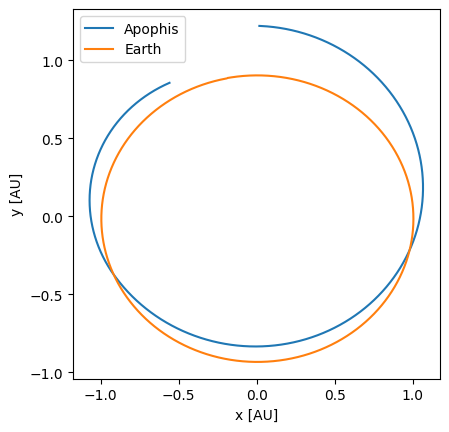

In [9]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("x [AU]"); ax.set_ylabel("y [AU]")
ax.plot(apophis_pos[:,0],apophis_pos[:,1], label="Apophis")
ax.plot(earth_pos[:,0],earth_pos[:,1], label="Earth")
ax.legend();

Let us zoom in on the close encounter by moving to a frame that is co-moving with Earth. The size of the Earth is shown to scale.

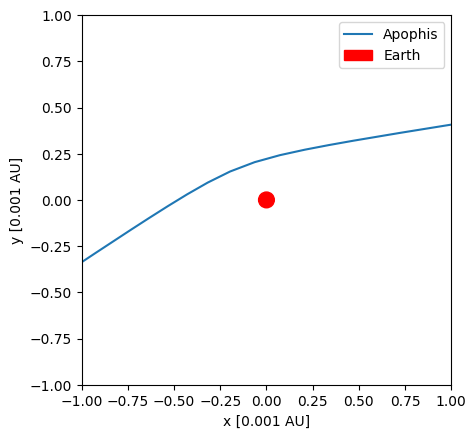

In [10]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("x [0.001 AU]"); ax.set_ylabel("y [0.001 AU]")
ax.set_xlim([-1,1]); ax.set_ylim([-1,1])
ax.plot((apophis_pos[:,0]-earth_pos[:,0])*1e3,(apophis_pos[:,1]-earth_pos[:,1])*1e3, label="Apophis")
c = plt.Circle((0,0),4.2587571e-02, color="r", label="Earth")
ax.add_patch(c)
ax.legend();